In [47]:
# CREA LOS PLANOS DE MADURACION PARA COSECHA

In [1]:
# IMPORTACIONES
import sys
sys.path.append('..')
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

import os
import geopandas as gpd
import pandas as pd
import re
from collections import namedtuple
import unicodedata
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib.patches import Patch
from docx.shared import Mm

import docxtpl
from docxtpl import DocxTemplate

In [2]:
RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

#path_tif = r"C:\Users\bismarksr\Downloads\SENTINEL_2025-02-12_UTM_2.tif"
path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2025-02-12_UTM.tif"
# Cargar la imagen TIFF con rasterio
with rasterio.open(path_tif) as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
    img = src.read([1, 2, 3])  # Leer las bandas RGB

In [3]:
def generar_plano_os(shp_prop, path_tif, path_out):
    colores_orden = {
        0: '#DDDDDD', # Sin datos
        1: '#FF0000',  # Rojo
        2: '#FF4500',  # Naranja fuerte
        3: '#FFA500',  # Naranja
        4: '#FFB733',  # Naranja claro
        5: '#FFD700',  # Amarillo fuerte
        6: '#FFFF00',  # Amarillo
        7: '#CCFF00',  # Verde lima claro
        8: '#99CC00',  # Verde lima medio
        9: '#669900',  # Verde pasto
        10: '#336600', # Verde oliva oscuro
        11: '#006600', # Verde oscuro
    }
    leyenda_textos = {
        0: 'Sin datos',
        1: 'Lotes Maduros (iniciar cosecha)',
        2: '',
        3: '',
        4: '',
        5: '',
        6: 'Madurez intermedia',
        7: '',
        8: '',
        9: '',
        10: '',
        11: 'Lotes con maduracion baja'
    }
    shp_prop = shp_prop.copy()
    shp_prop['color'] = shp_prop['orden2'].map(colores_orden)
    
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='black', facecolor=shp_prop['color'], linewidth=1)
    
    # Agregar etiquetas con lote mas area
    for idx, row in shp_prop.iterrows():
        if row.geometry is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geometry.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))
    
    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])
    
    # Leyenda dinámica para colores por orden
    legend_colores = [
        Patch(facecolor=colores_orden[orden], edgecolor='black', label=leyenda_textos[orden])
        for orden in colores_orden
    ]
    # Mostrar la leyenda
    ax.legend(handles=legend_colores, loc='upper right', fontsize=9,
              frameon=True, facecolor='white', edgecolor='black')
    out = os.path.join(path_out, str(shp_prop["unidad_02"].iloc[0]) + '.jpg')
    # Guardar plano
    fig.savefig(path_out, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

In [4]:
# Ruta completa al archivo .shp (cambia el nombre del archivo por el que necesitas)
ruta_shp =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\MADURACION\SHP\LOTES_MADURACION_2.shp"
# Cargar shapefile
gdf_cat = gpd.read_file(ruta_shp)
gdf_cat = gdf_cat[['unidad_01', 'unidad_02','unidad_03', 'unidad_04', 'unidad_05', 'area', 'orden2', 'geometry']]

In [5]:
# Ruta completa de grupos
ruta_grupos =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\DATA\GRUPO_COSECHA.xlsx"
# Cargar datos
df_grupos = pd.read_excel(ruta_grupos, sheet_name = 'CODIGOS')
df_grupos.head(3)

CODIGO CAÑERO                NOMBRE CAÑERO  GRUPO DE COSECHA  INSTITUCION  \
0            742     ACSAMA ELVIRA AMURRIO DE               356        131.0   
1          42034        ACSAMA MAMANI TEODORA               482         63.0   
2            465  ACSAMA SALVADOR MARIO REYES               356        131.0   

  DELEGADO      obs    ver  
0      NaN    742.0  131.0  
1      NaN  42034.0   63.0  
2      NaN    465.0  131.0

In [6]:
# Ruta completa de grupos
ruta_grupos =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\DATA\GRUPO_COSECHA.xlsx"
# Cargar datos
df_grupos = pd.read_excel(ruta_grupos, sheet_name = 'CODIGOS')

#Limpiar nombres de columnas
def limpiar_nombre(col):
    col = col.strip().lower()
    col = unicodedata.normalize('NFKD', col).encode('ascii', 'ignore').decode('utf-8')  # elimina tildes y ñ
    col = re.sub(r'\W+', '_', col)  # reemplaza cualquier no-alfanumérico por _
    return col

df_grupos.columns = [limpiar_nombre(col) for col in df_grupos.columns]

In [7]:
df_grupos

codigo_canero                nombre_canero  grupo_de_cosecha  \
0               742     ACSAMA ELVIRA AMURRIO DE               356   
1             42034        ACSAMA MAMANI TEODORA               482   
2               465  ACSAMA SALVADOR MARIO REYES               356   
3                17        ACSAMA SEGOVIA SABINO               356   
4                18        ACUNA ARISPE HONORATO               354   
...             ...                          ...               ...   
1412          41548       ZAPATA CKOLO ALEXANDER               278   
1413          42017         ZAPATA CKOLO YOSELIN               278   
1414          16213           ZAPATA SERON SIMON               278   
1415          13132        ZUMARAN MENACHO JORGE               409   
1416          16554         ZURITA CASTRO MARTIN               271   

      institucion  delegado      obs    ver  
0           131.0       NaN    742.0  131.0  
1            63.0       NaN  42034.0   63.0  
2           131.0       NaN    465.0  131.0  
3           131.0  DELEGADO     17.0  131.0  
4           126.0       NaN     18.0  126.0  
...           ...       ...      ...    ...  
1412         68.0       NaN  41548.0   68.0  
1413         68.0       NaN  42017.0   68.0  
1414         68.0  DELEGADO  16213.0   68.0  
1415         50.0  DELEGADO  13132.0   50.0  
1416         68.0       NaN  16554.0   68.0  

[1417 rows x 7 columns]

In [33]:
cod_grupo= 52

grupo = df_grupos[df_grupos['grupo_de_cosecha'] == cod_grupo]

# Convertir cada fila a namedtuple usando .to_dict()
grupo_obj = []
for _, row in grupo.iterrows():
    fila_dict = row.to_dict()
    Tupla = namedtuple("grupo", fila_dict.keys())
    objeto = Tupla(*fila_dict.values())
    grupo_obj.append(objeto)

cods_ca = list(set(grupo['codigo_canero']))

df_filtrado = gdf_cat[gdf_cat['unidad_03'].isin(cods_ca)]
cods_prop = list(set(df_filtrado['unidad_01']))
props = [int(i) for i in cods_prop]
props

[1094,
 631,
 1655,
 1097,
 365,
 798,
 848,
 849,
 784,
 1087,
 852,
 630,
 919,
 1852,
 797,
 894,
 895]

In [34]:
grupo

codigo_canero                    nombre_canero  grupo_de_cosecha  \
28             2569  AGROPECUARIA CUPESI VARGAS SRL.               398   
33              682       AGROPECUARIA RENATA S.R.L.               398   
1319          17586       VARGAS CESPEDES MARIO RENE               398   
1321          14744         VARGAS FAUSTINA PINTO DE               398   
1331          14760                VARGAS PINTO RENE               398   
1332          15001         VARGAS PINTO RENNY EDWIN               398   
1333          15080             VARGAS PINTO ROSMERY               398   
1344          14769              VARGAS URIONA MARIO               398   
1347          42562    VARGAS ZAMBRANA MARIO RODRIGO               398   
1348          15081   VARGAS ZAMBRANA RENY SEBASTIAN               398   
1409          16719            ZAMBRANA VACA ARACELY               398   

      institucion  delegado      obs   ver  
28           79.0       NaN   2569.0  79.0  
33           79.0       NaN    682.0  79.0  
1319         79.0       NaN  17586.0  79.0  
1321         79.0       NaN  14744.0  79.0  
1331         79.0       NaN  14760.0  79.0  
1332         79.0  DELEGADO  15001.0  79.0  
1333         79.0       NaN  15080.0  79.0  
1344          NaN       NaN  14769.0   NaN  
1347         79.0       NaN      NaN  79.0  
1348         79.0       NaN  15081.0  79.0  
1409         79.0       NaN  16719.0  79.0

G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\1094_SAN LORENZO VARGAS I--VARGAS PINTO.jpg
1094
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\631_LA PATRIA VARGAS II--VARGAS.jpg
631
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\1655_EL RECUERDO I Y II--VARGAS RENE.jpg
1655
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\1097_NARANJO VARGAS--VARGAS RENE.jpg
1097
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\365_TUROBITO CUPECI--VARGAS.jpg
365
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\798_EL RECUERDO X--VARGAS FAUSTINA.jpg
798
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\848_RIO HONDO VARGAS I--VARGAS RENE.jpg
848
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\849_RIO HONDO VARGAS II--VARGAS RENE.jpg
849
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\784_SAN LORENZO--VARGAS.jpg
784
G:\OneDrive - Ingenio Azucarero Guabir

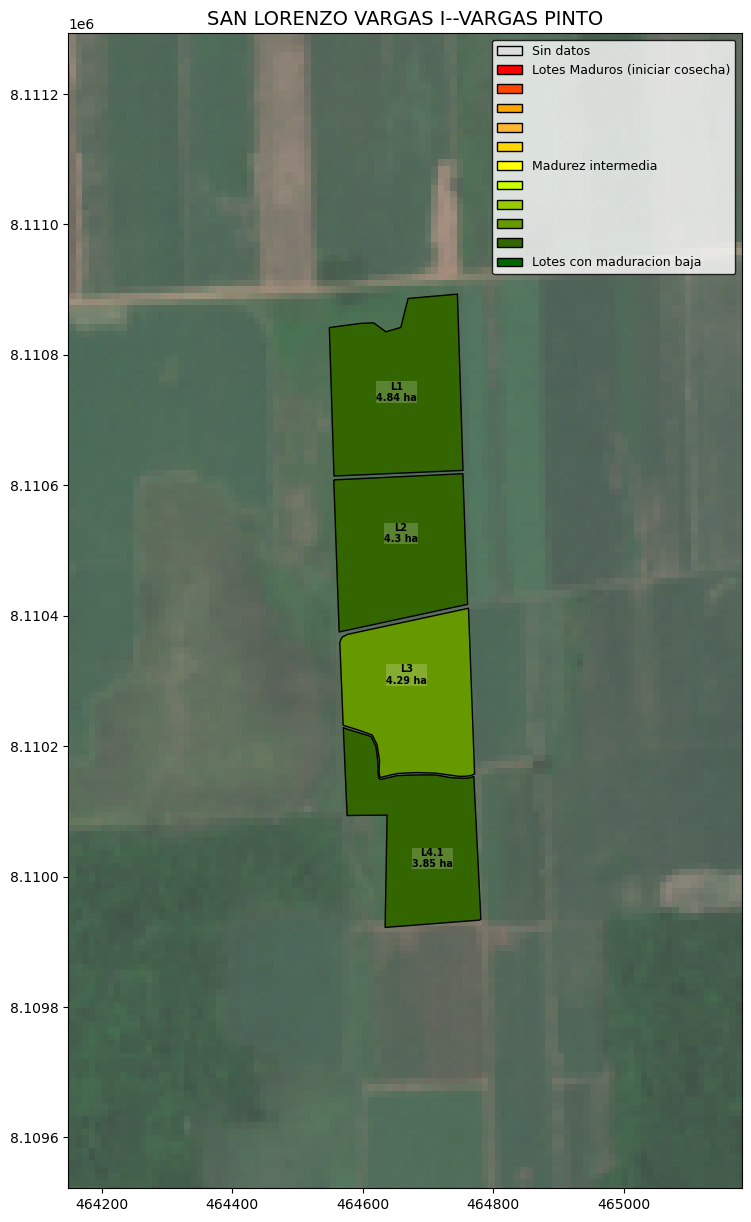

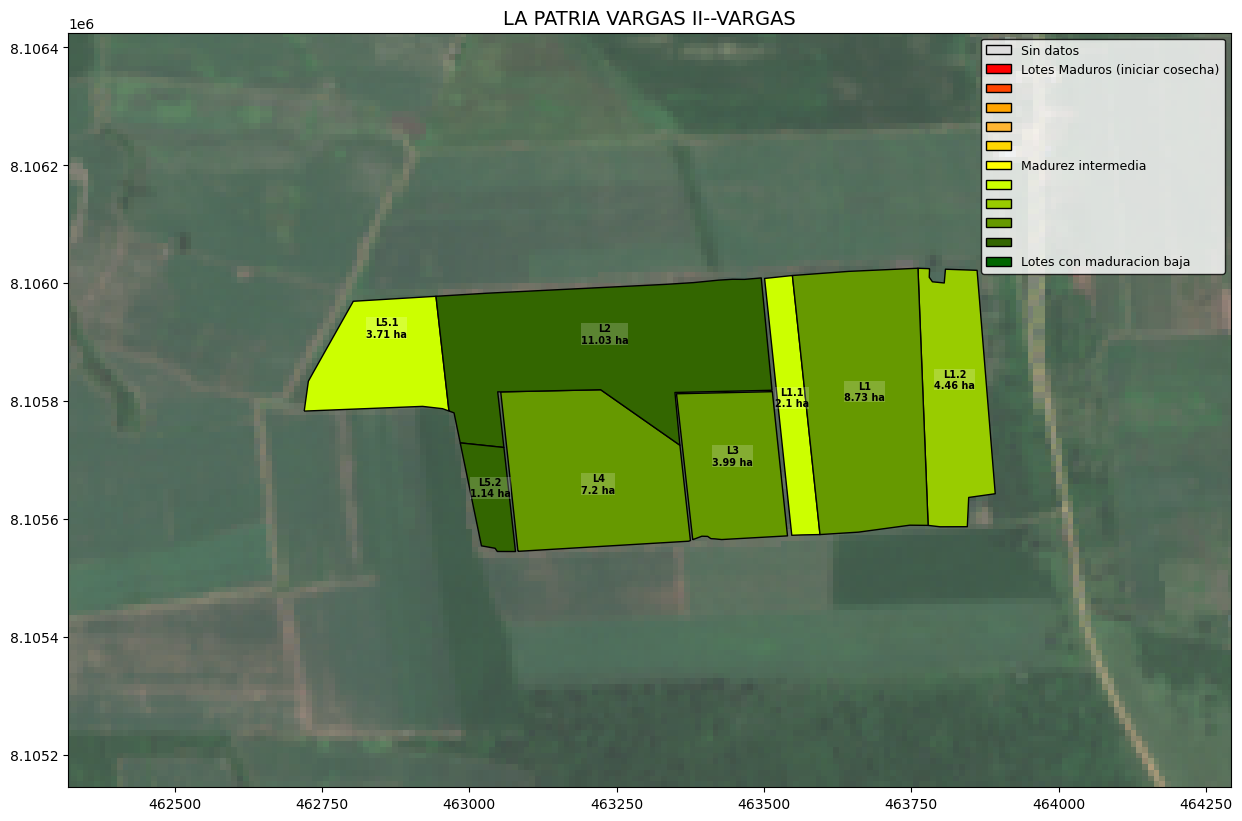

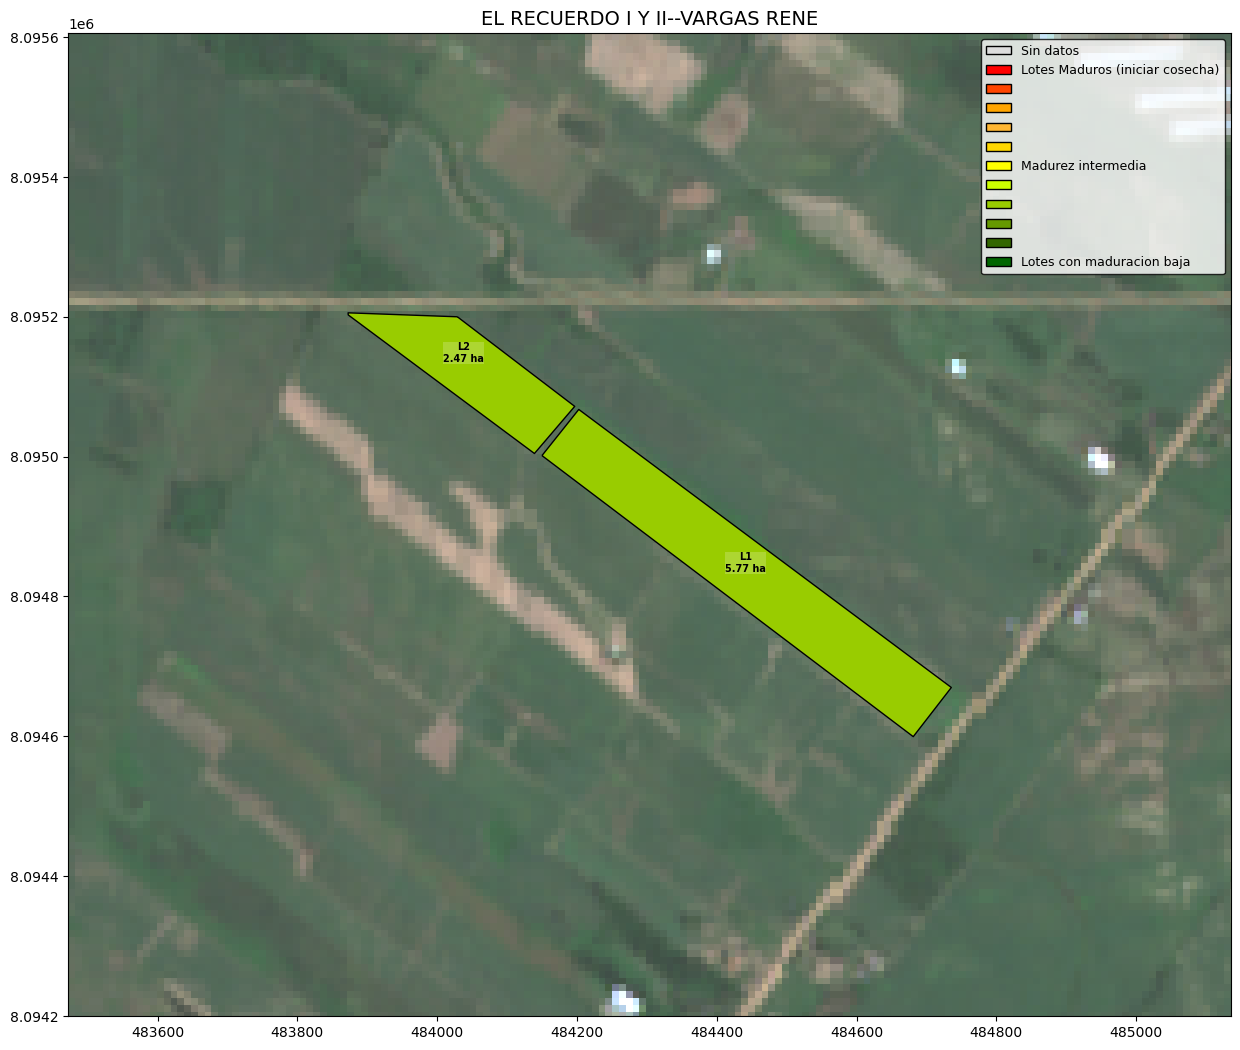

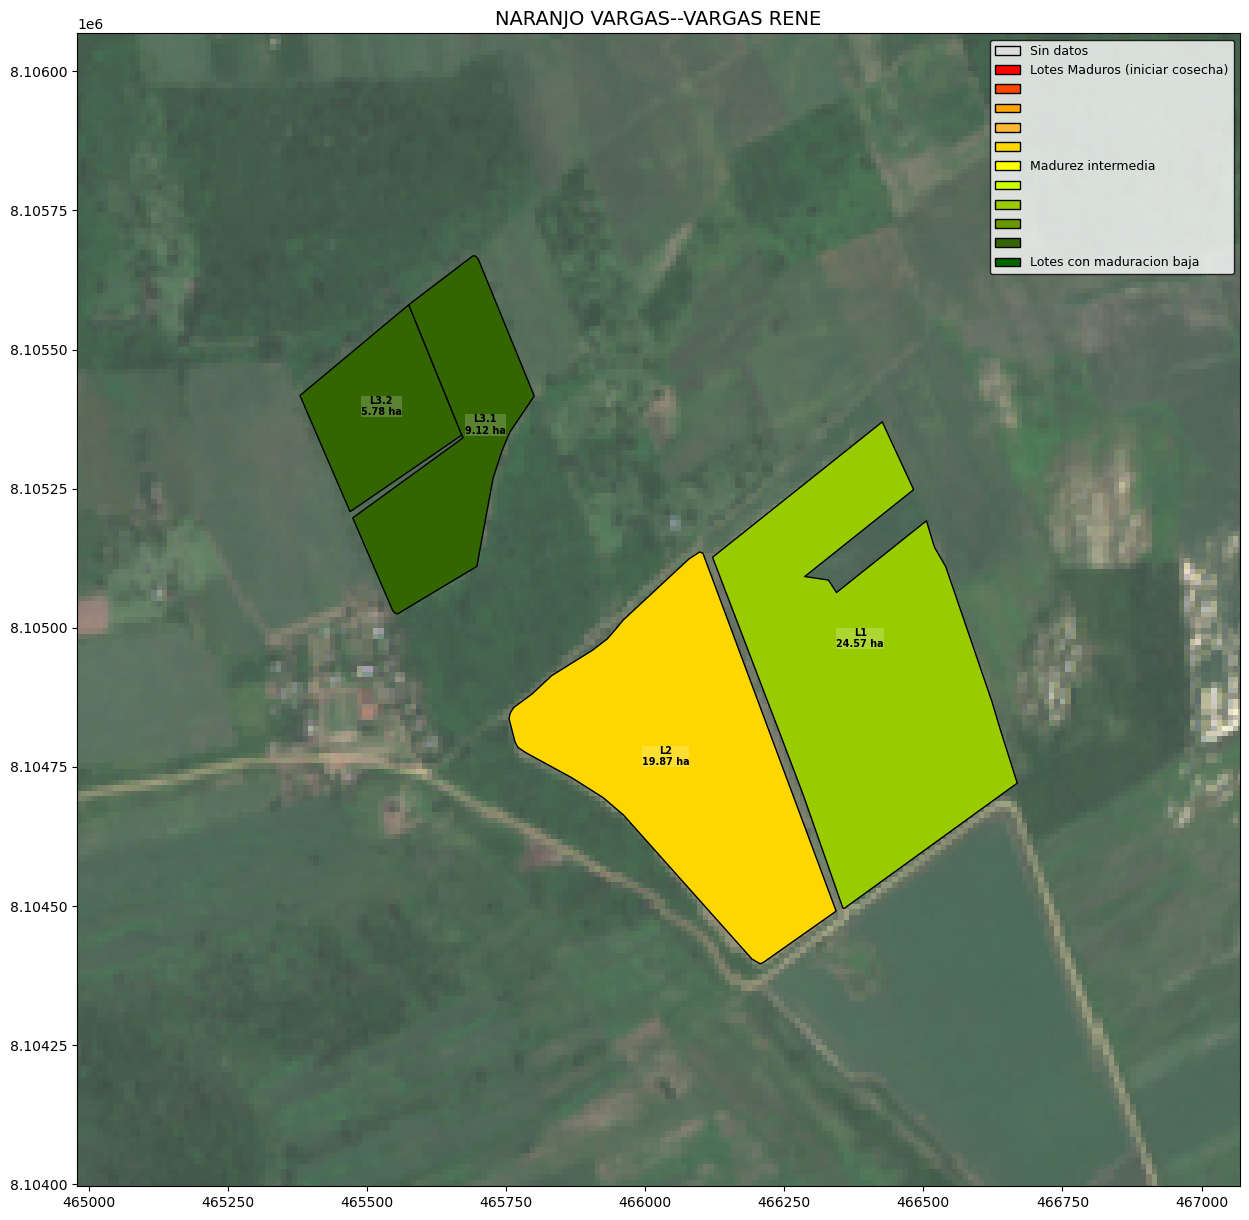

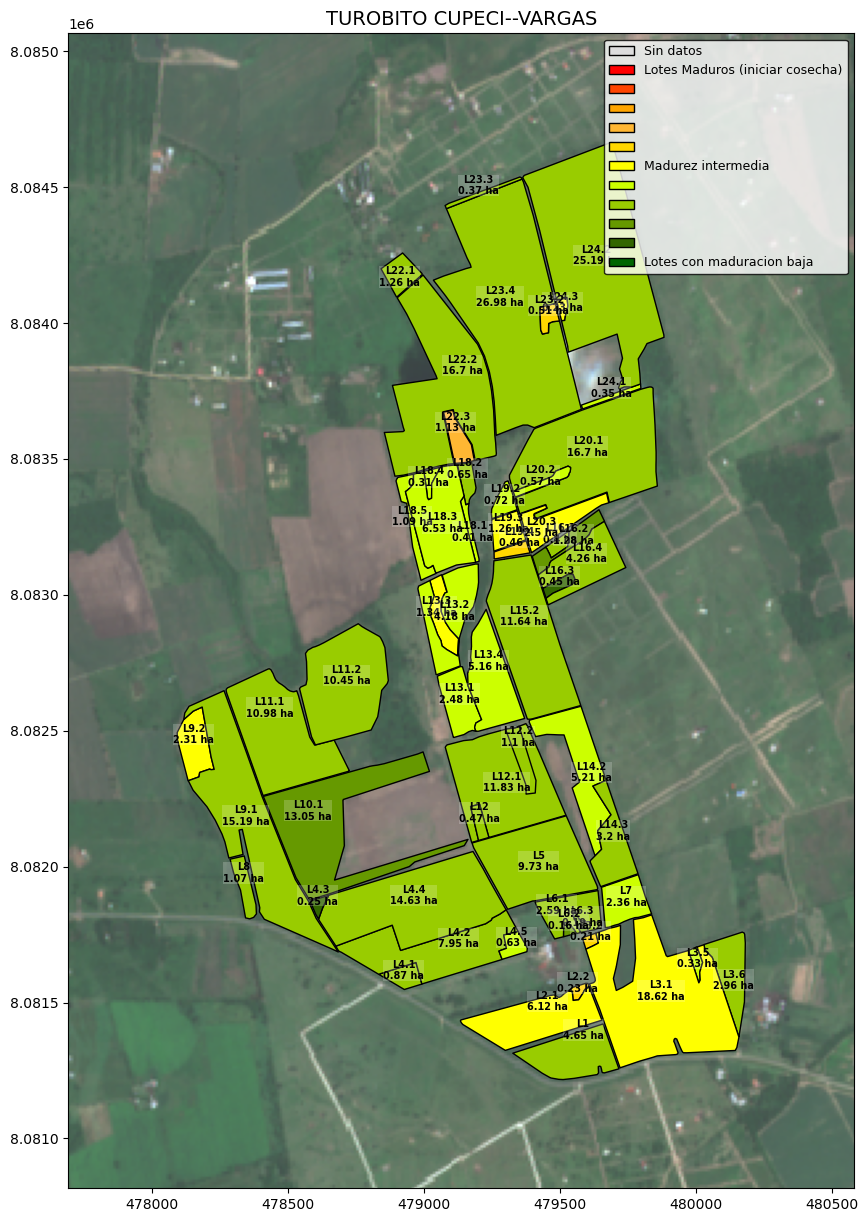

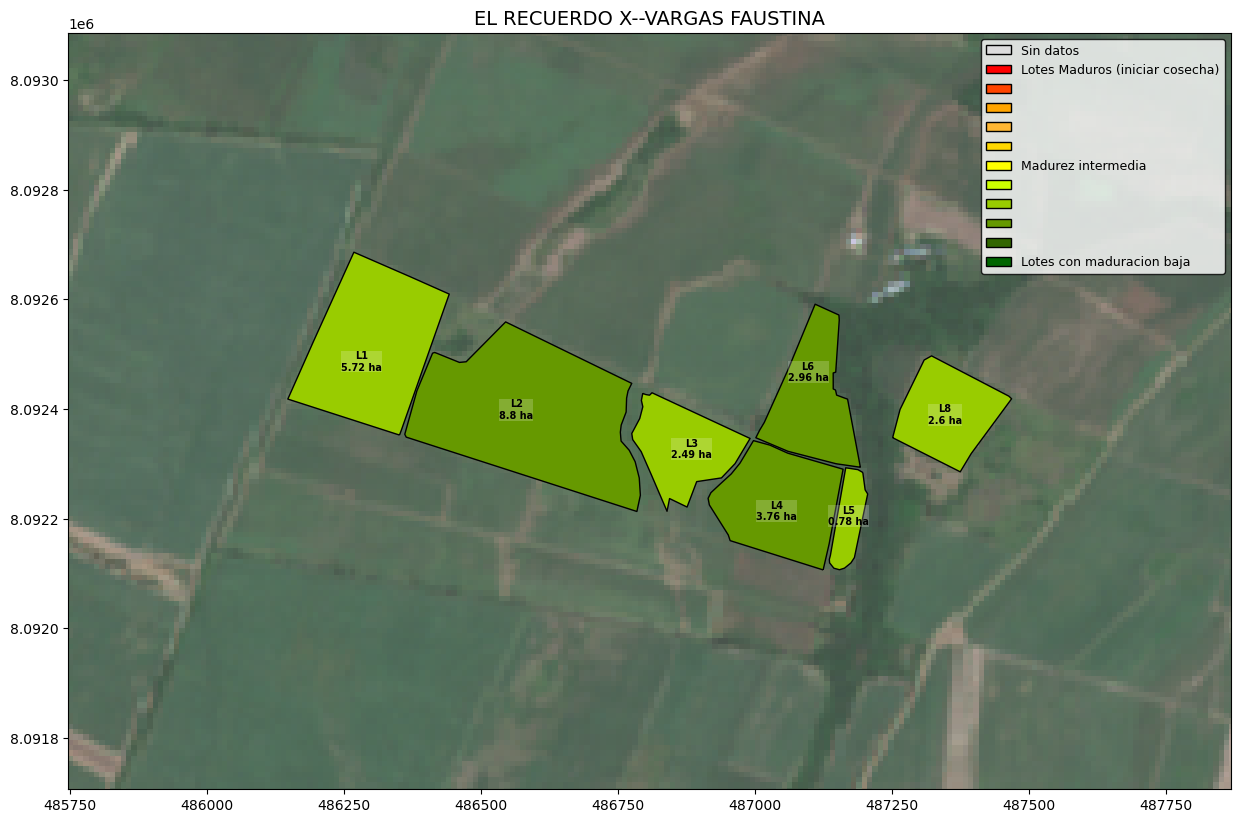

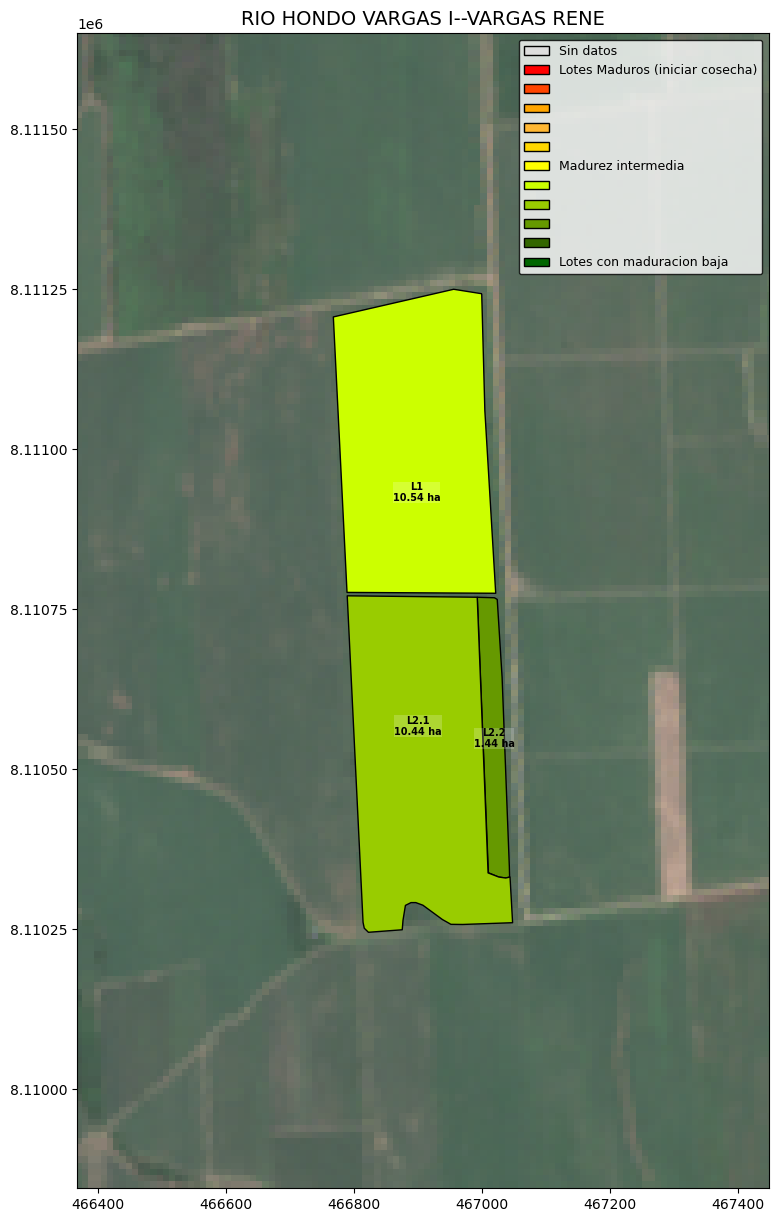

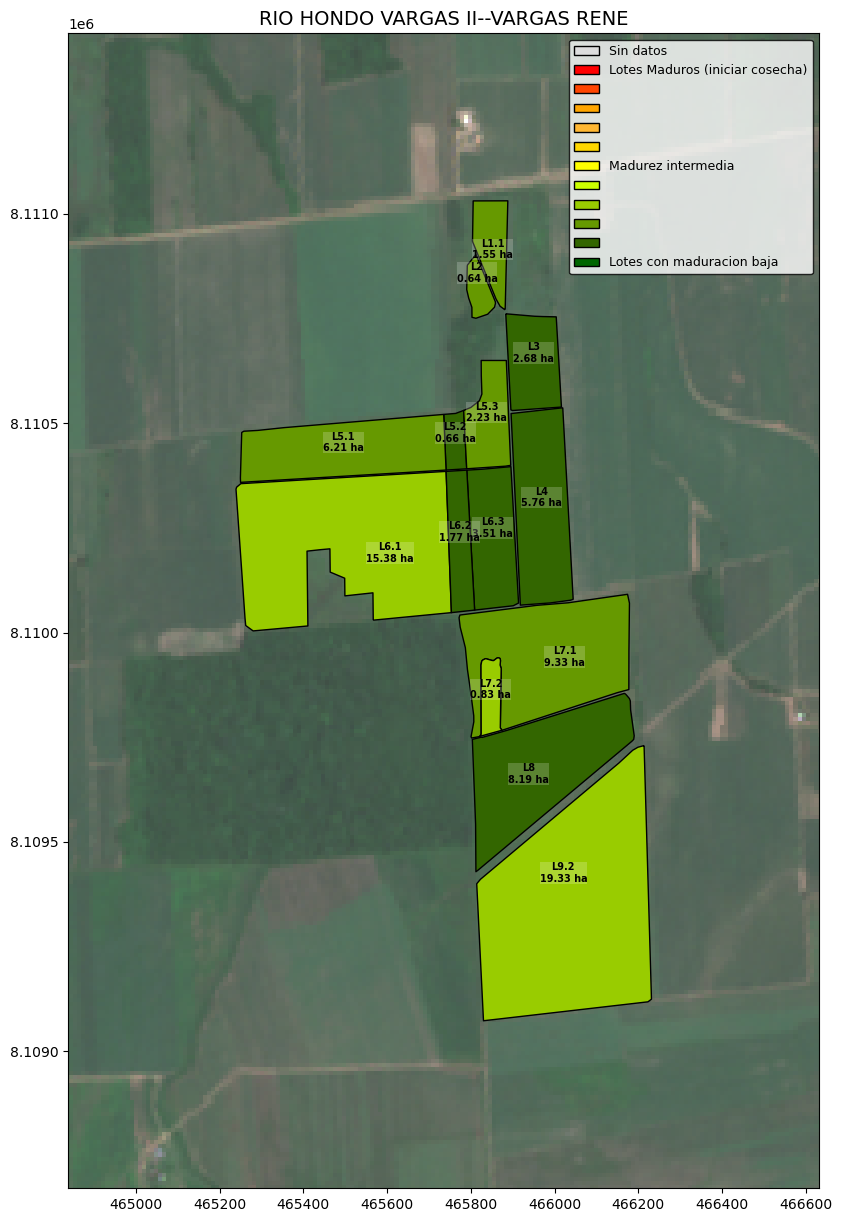

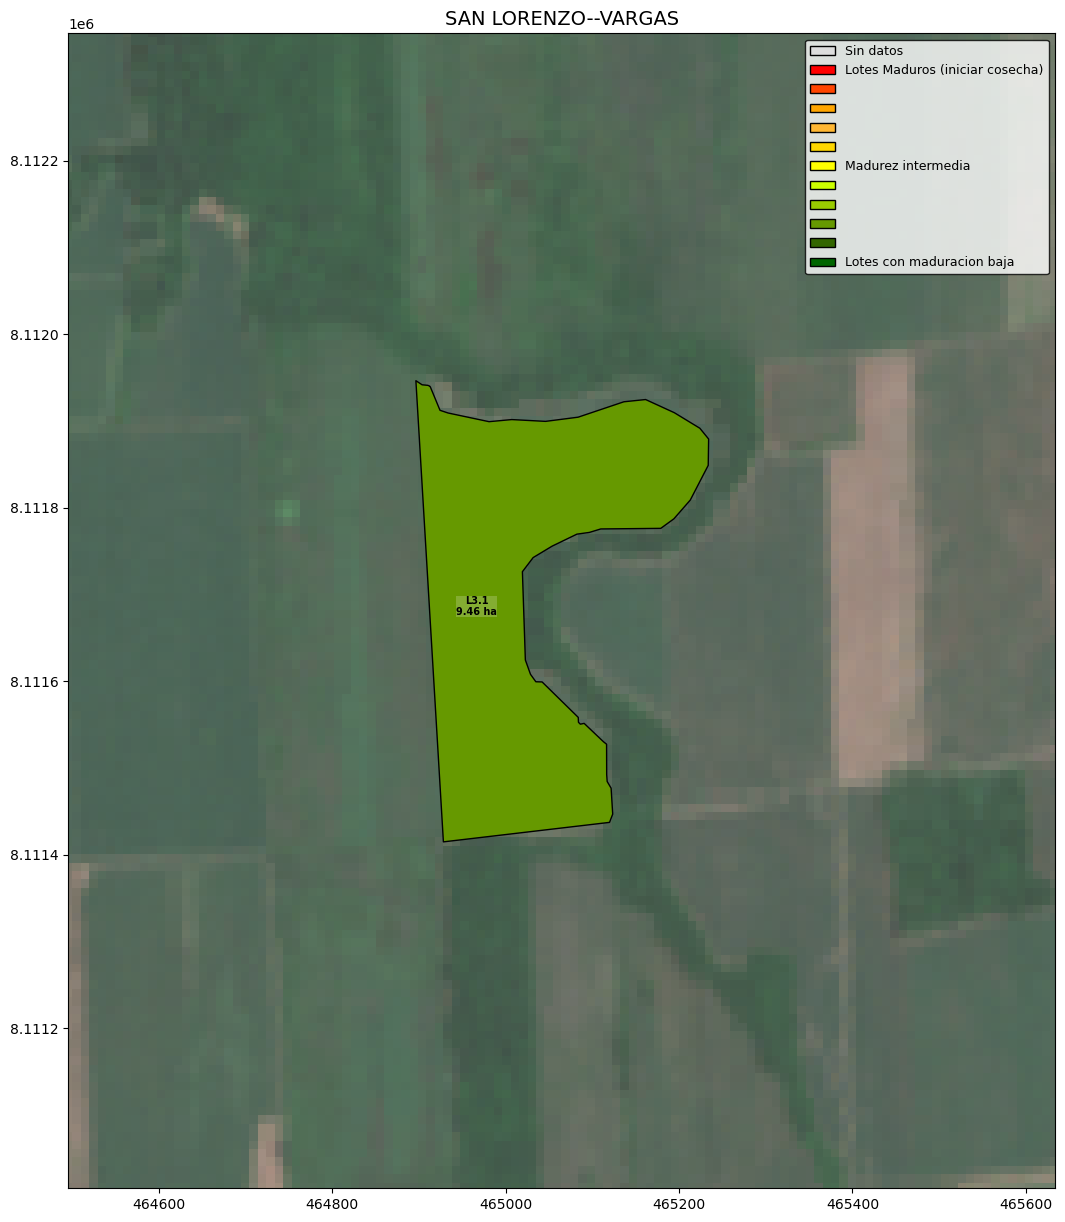

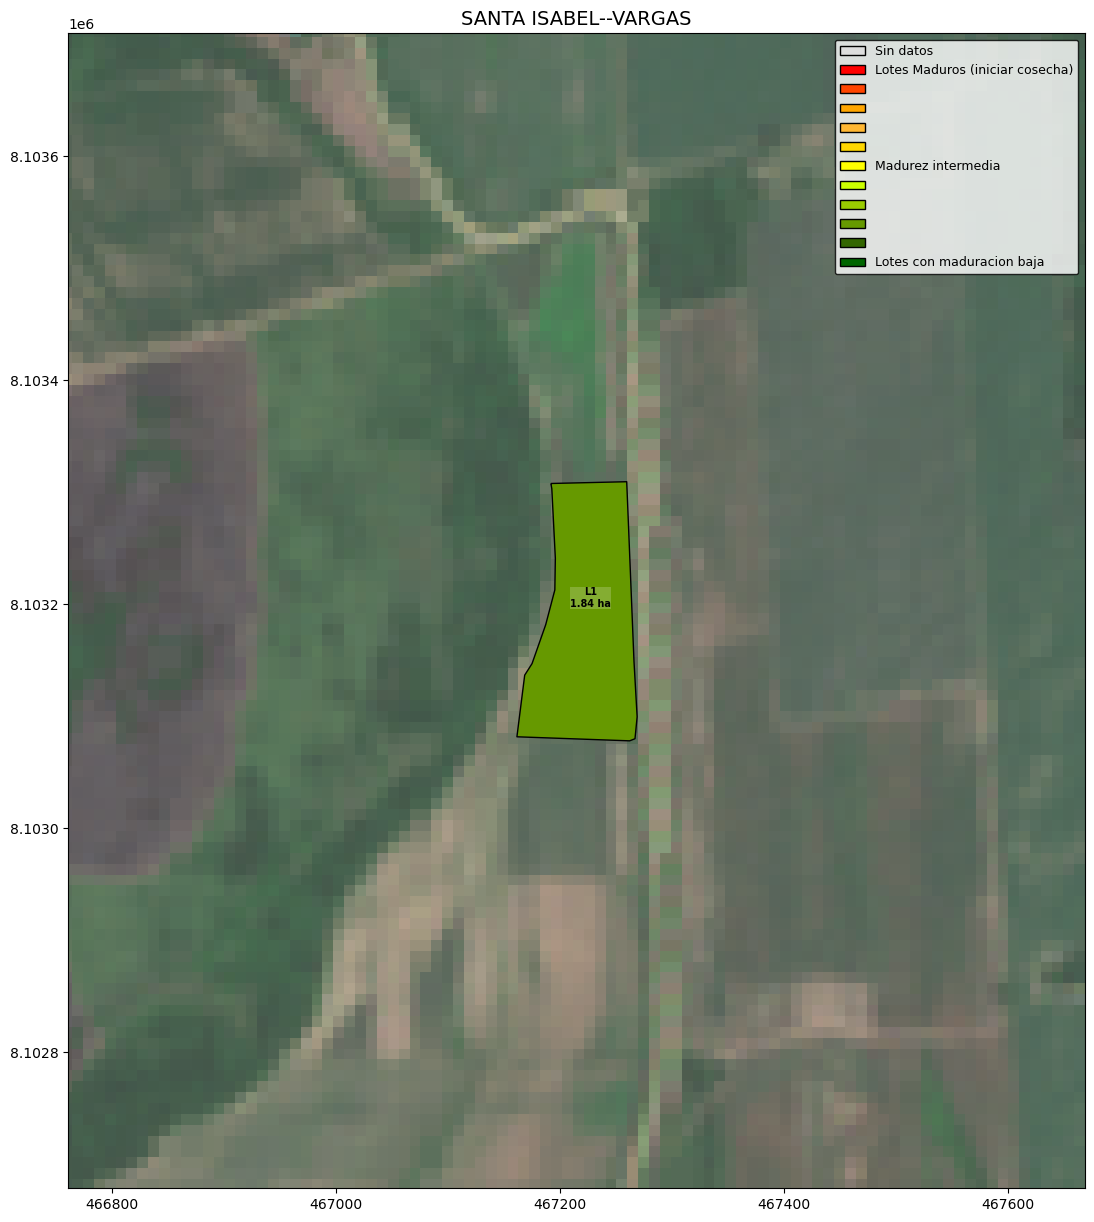

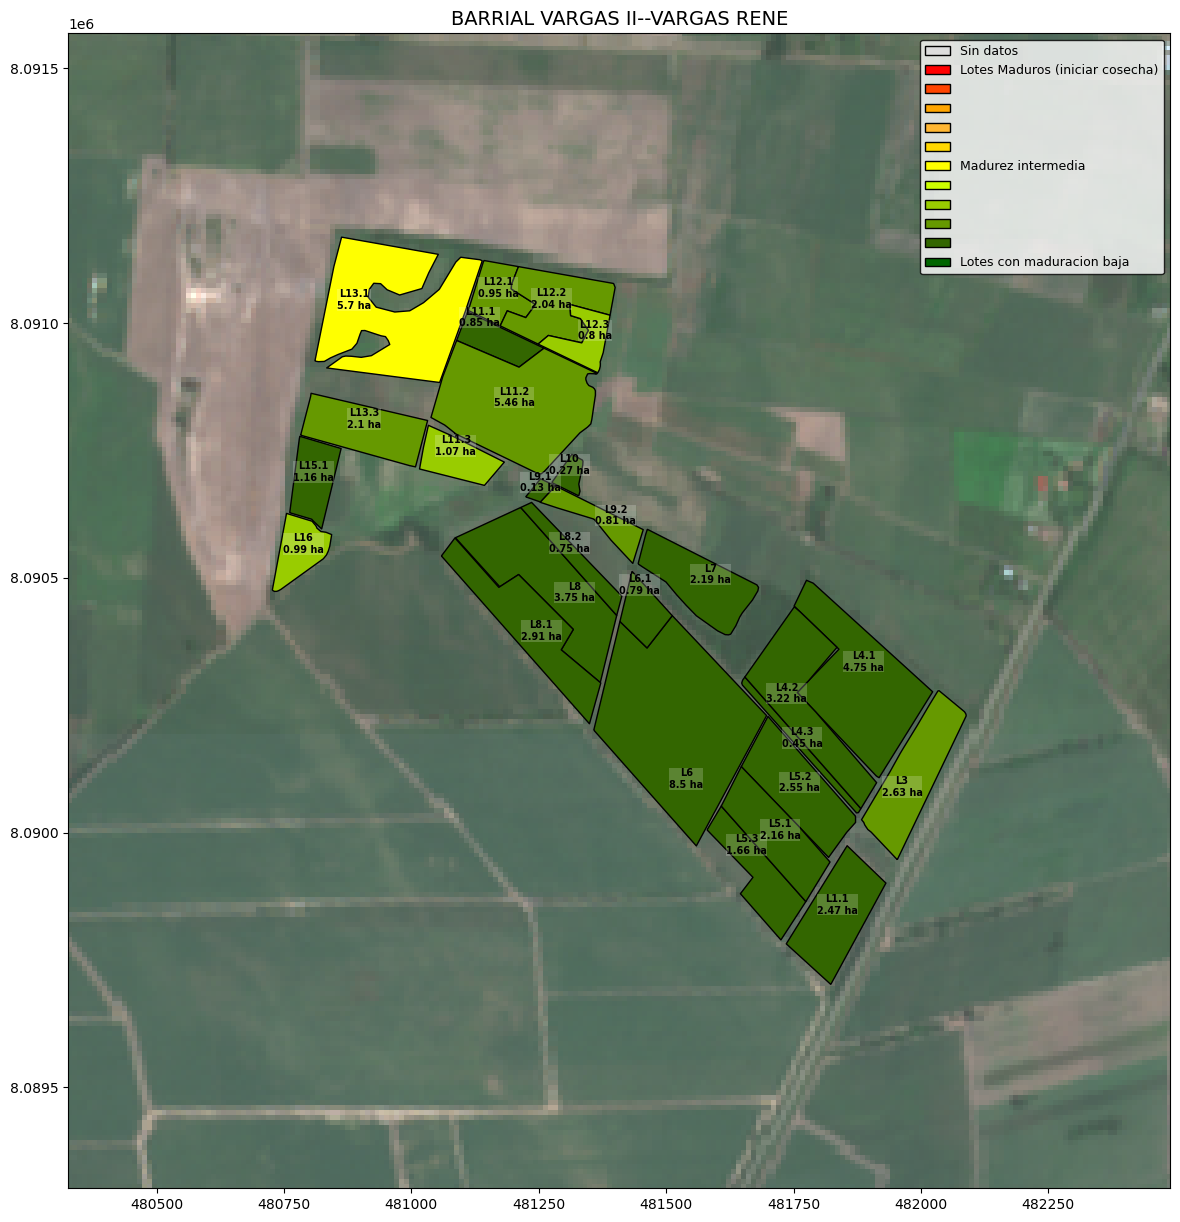

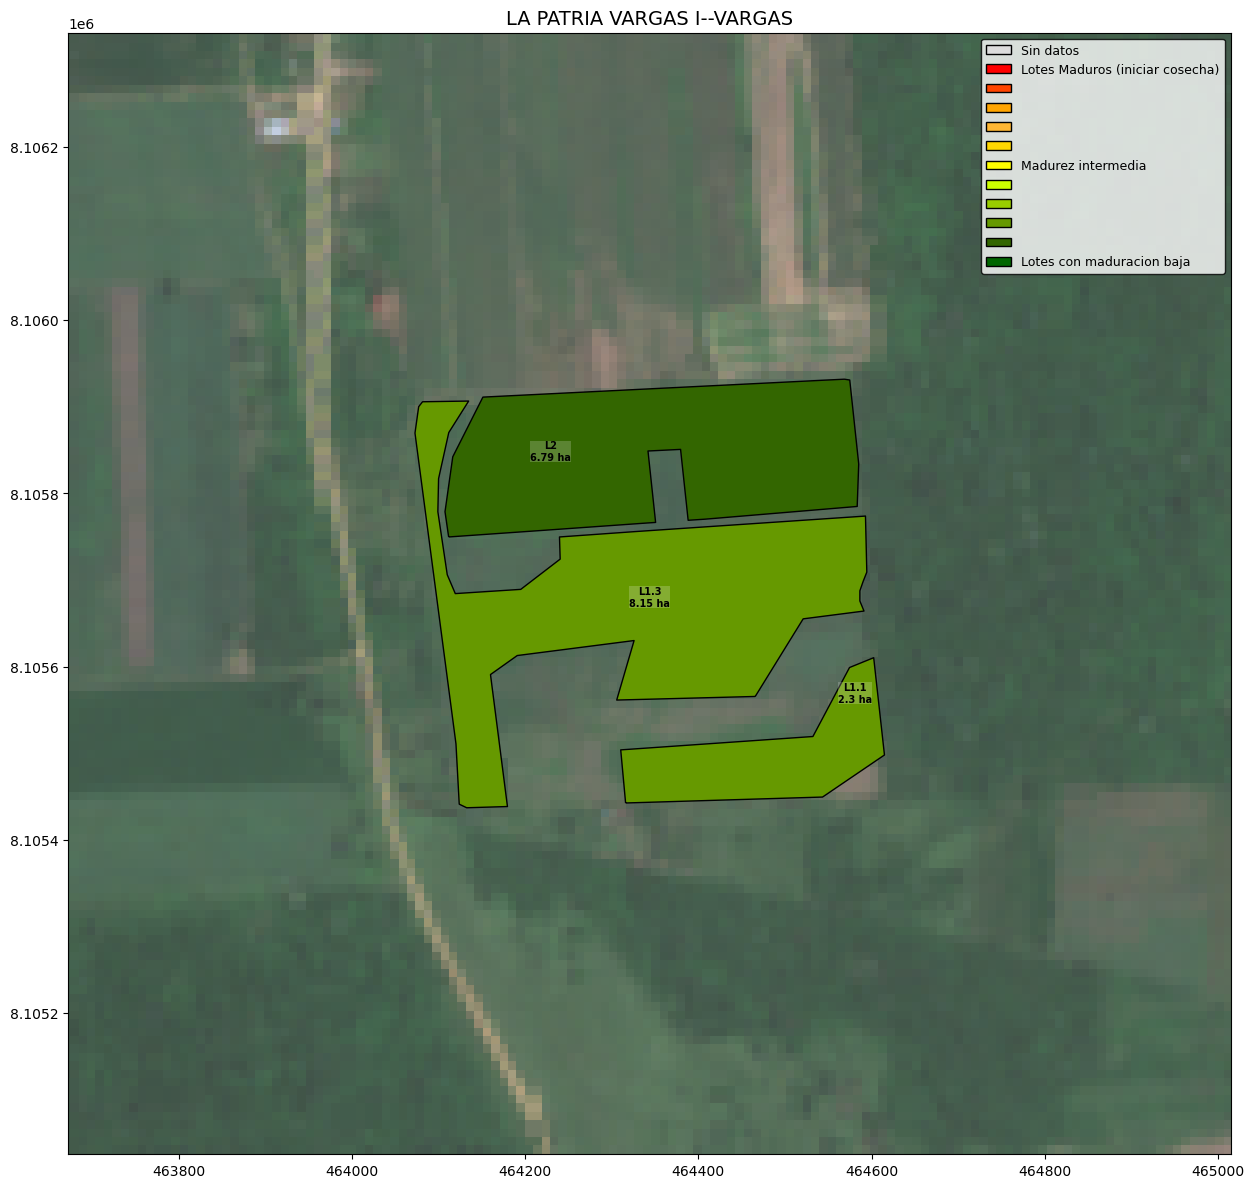

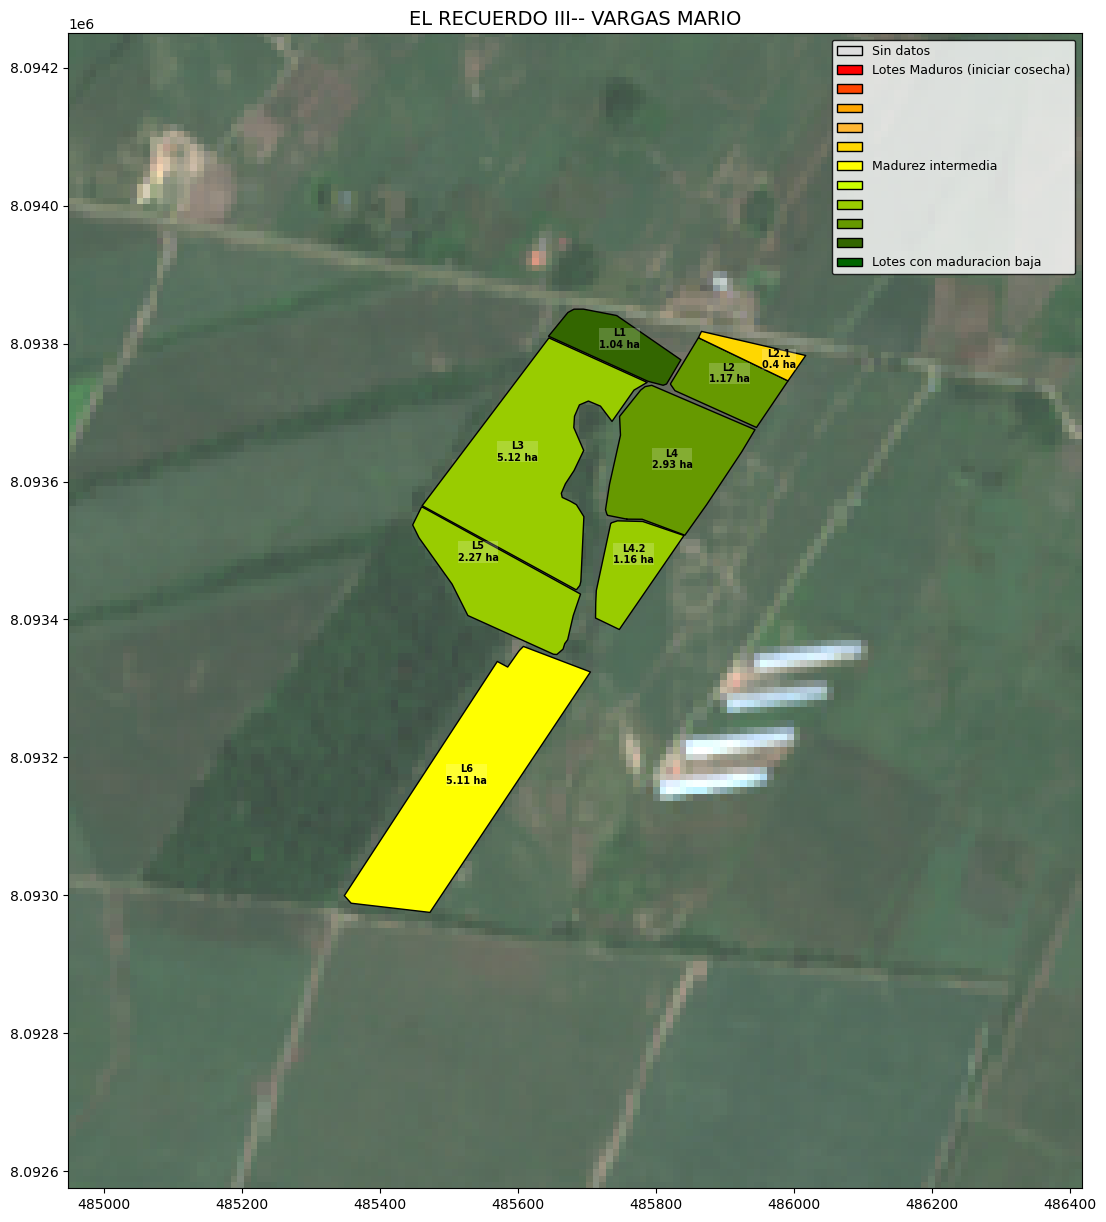

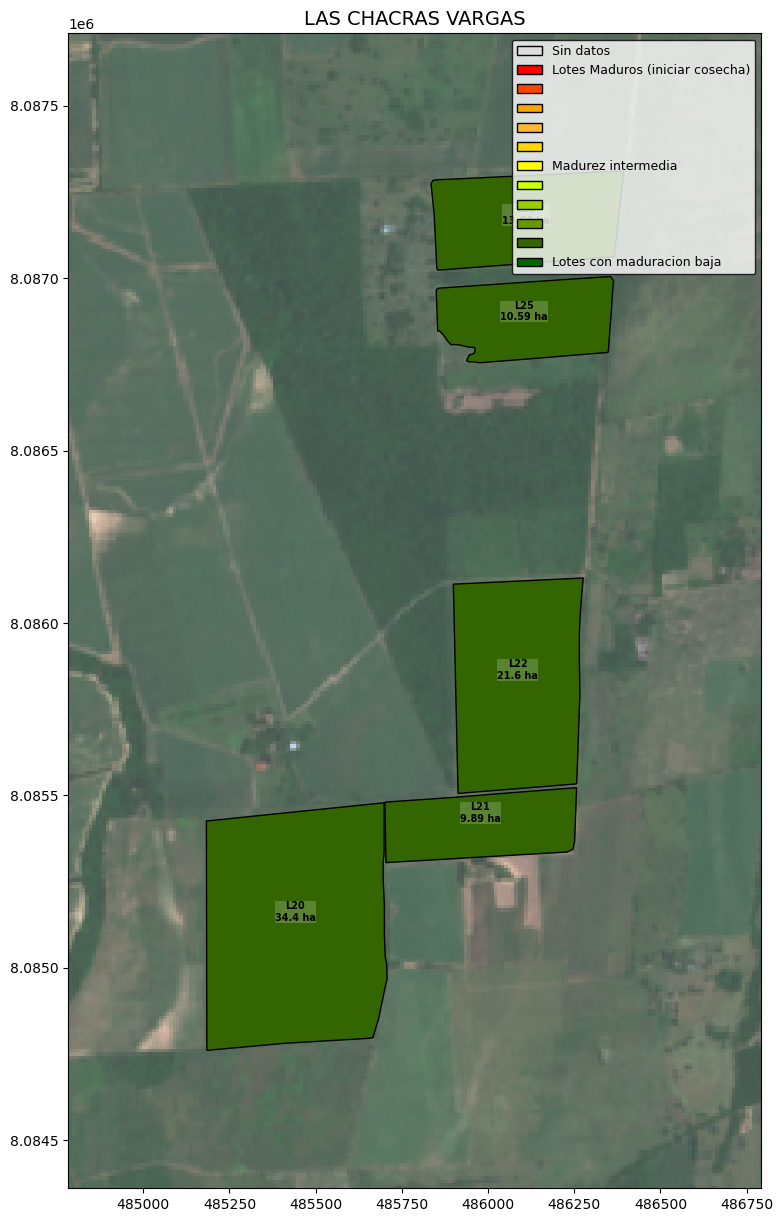

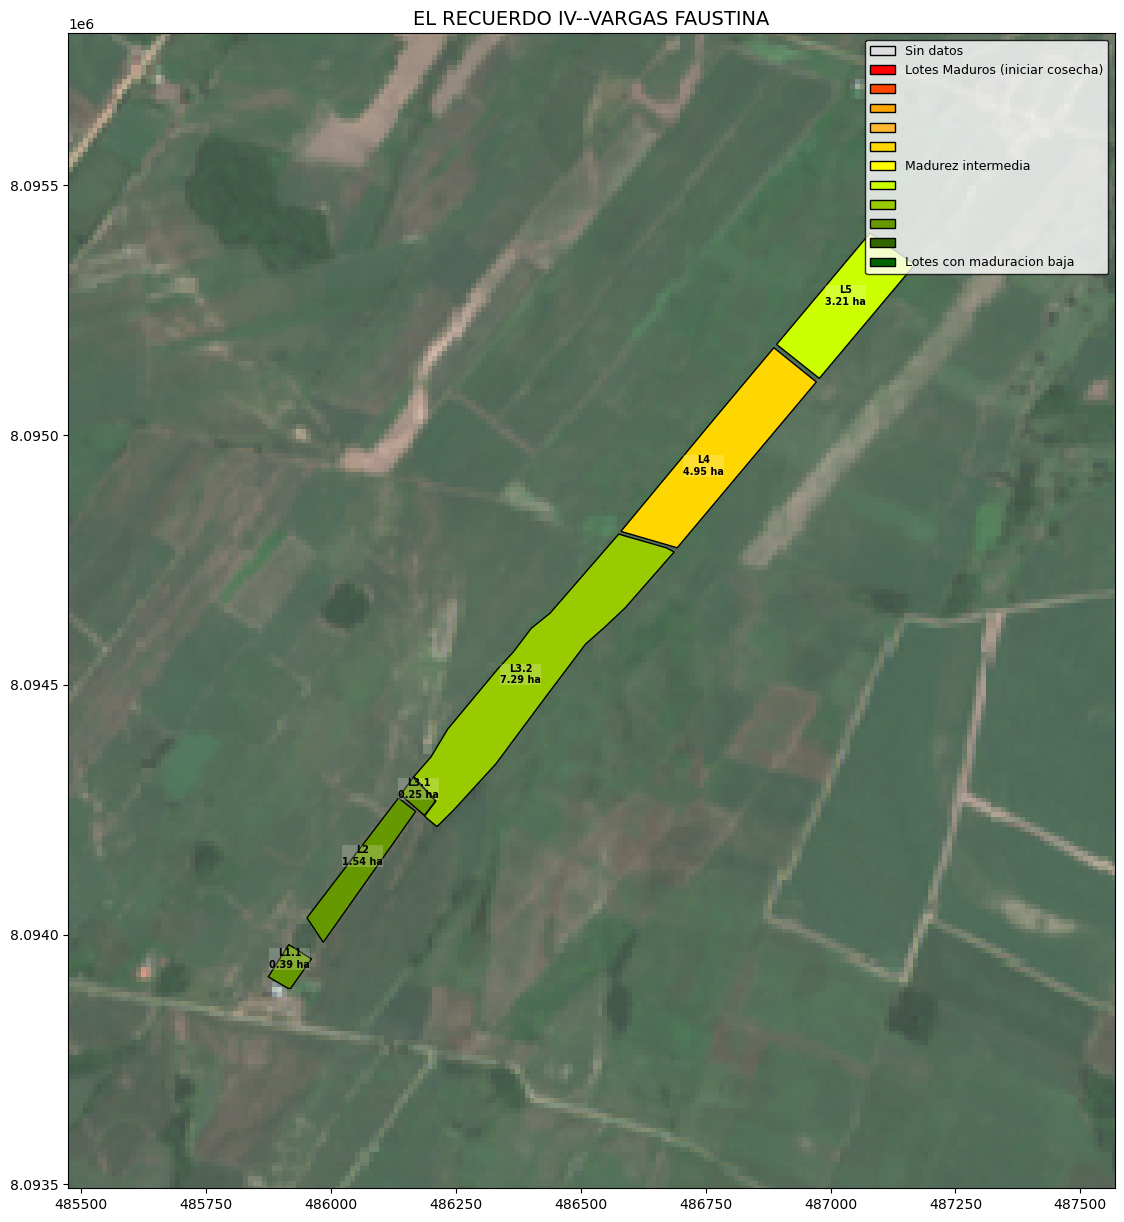

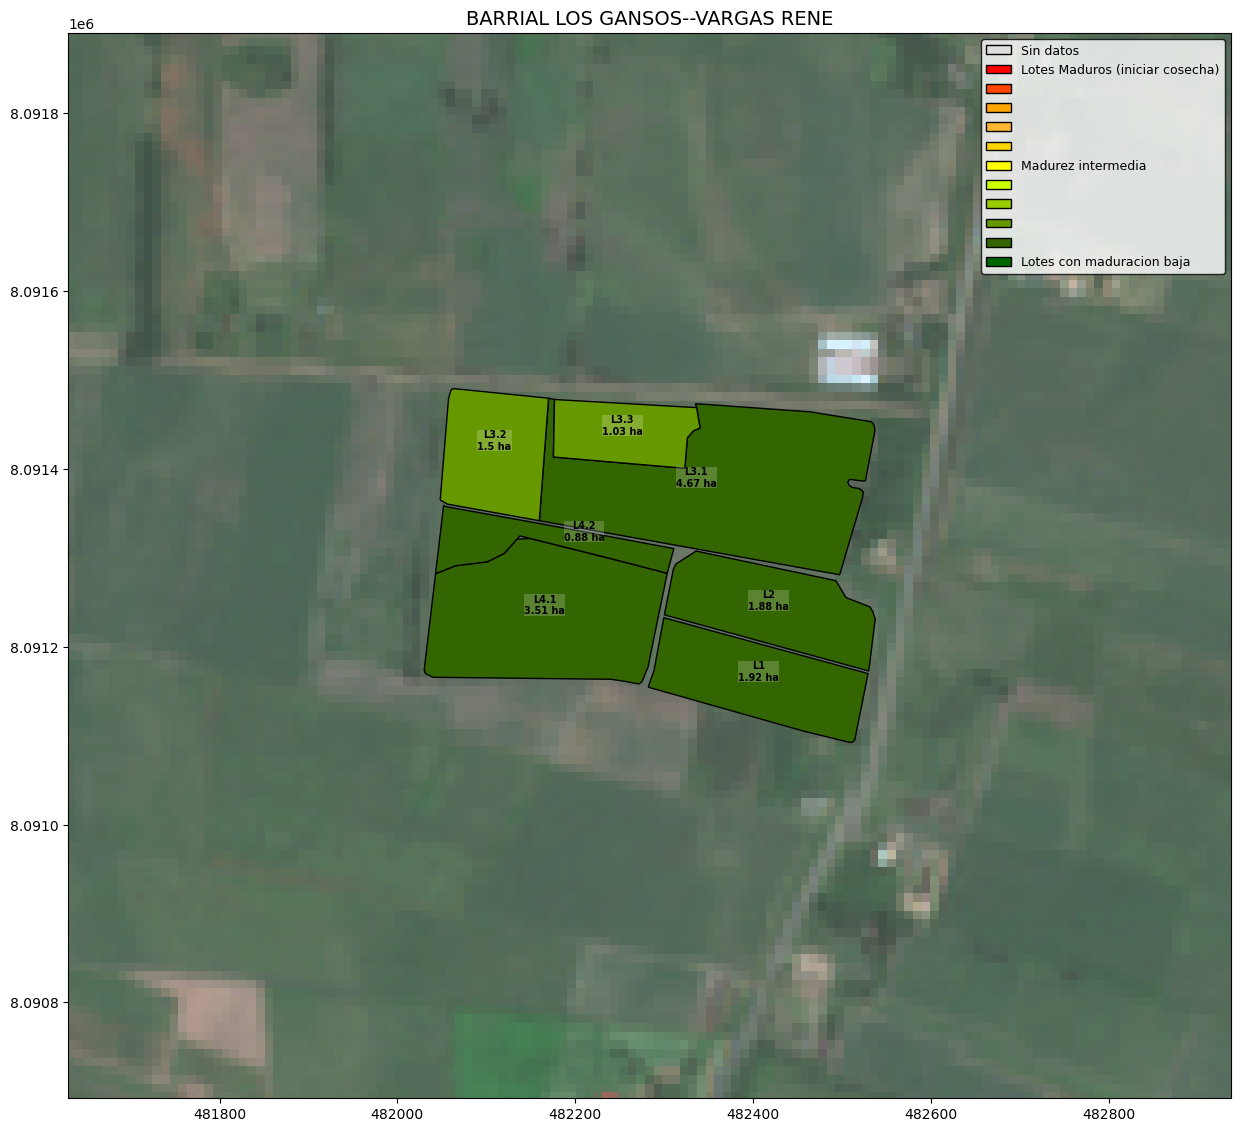

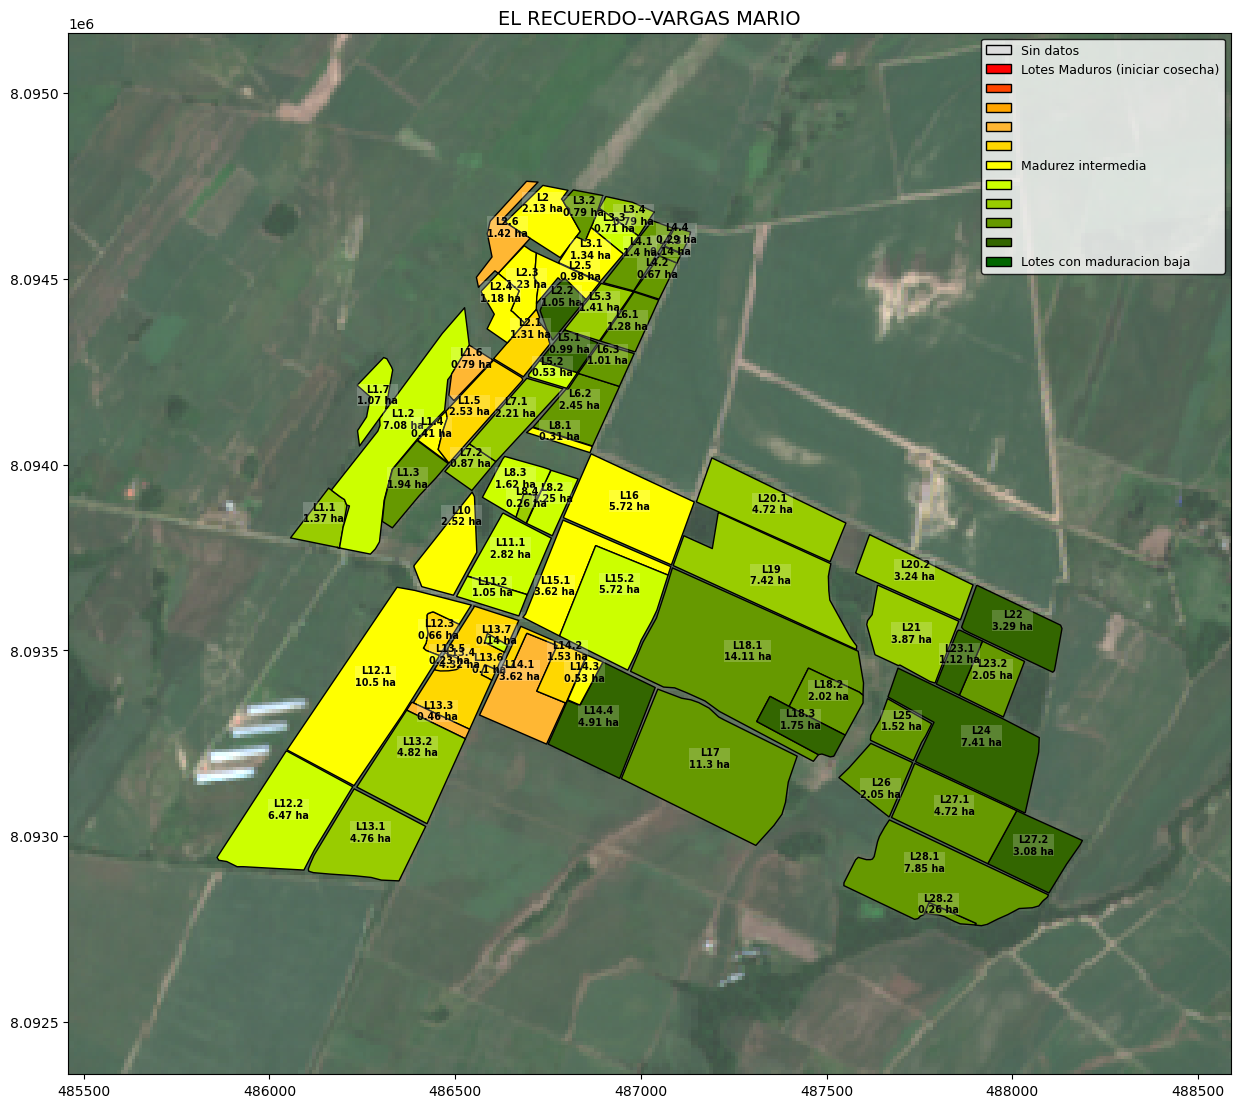

In [35]:
rutas_planos = []
for i in props:
    prop = gdf_cat[gdf_cat['unidad_01'] == i]
    prop = prop.copy()
    # Obtener los valores de unidad_01 y unidad_02
    prop['unidad_01'] = prop['unidad_01'].astype(int)
    unidad_01 = prop['unidad_01'].iloc[0]
    unidad_02 = prop['unidad_02'].iloc[0]
    # Crear el nombre del archivo concatenando unidad_01 y unidad_02
    nombre_archivo = f'{unidad_01}_{unidad_02}'
    path_plano = os.path.join(RUTA_COMPLETA, "planos", nombre_archivo + '.jpg')
    print(path_plano)
    generar_plano_os(prop, path_tif, path_plano)
    rutas_planos.append(path_plano)
    print(i)

In [36]:
doc = DocxTemplate(RUTA_COMPLETA + "/templates/tpl_rpt_maduracion.docx")
lista_InlineImage = []
for plano in rutas_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

context = {'grupo':grupo_obj, 'planos':lista_InlineImage}
doc.render(context)
file_name = f"_{grupo_obj[0].grupo_de_cosecha}" 
doc.save(RUTA_COMPLETA + '/informes/' + file_name + '.docx')